# Scatter Ptychography for Field Reflective System
### ZD
### 11/01/22

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.measure import block_reduce
from scipy import ndimage

import torch
import torch.nn as nn
import torch.nn.functional as F

import random

_seed = 38

random.seed(_seed)
np.random.seed(_seed % 2**32)
torch.manual_seed(_seed)

device='cuda' ## set to 'cpu' if cuda is unavailable
target = 'HV_bars'

In [2]:
## helper functions

def print_stat(narray, narray_name = 'Array'):
    print(narray_name + f" shape: {narray.shape}, dtype: {narray.dtype}")
    arr = narray.flatten()
    print(narray_name + " stat: max: {}, min: {}, mean: {}, std: {}".format(arr.max(), arr.min(), arr.mean(), arr.std()))

def pad_to_size(img, size):
    h, w = img.shape
    assert h <= size and w <= size
    left = (size - w)//2
    top = (size - h) //2
    
    if isinstance(img, np.ndarray):  
        return np.pad(img, ((top, size-h-top), (left, size-w-left)))
    else:
        return F.pad(img, (left, size-w-left, top, size-h-top))

def crop_to_size(img, size, offset=0):
    h, w = img.shape
    assert h >= size and w >= size
    left = (w - size)//2+offset 
    top = (h - size)//2+offset
    return img[top:top+size, left:left+size]

def show_stats(complex_img):
    plt.imshow(torch.abs(complex_img).to('cpu').numpy(), cmap='gray')
#     plt.title('Amplitude')
    plt.show()
    print_stat(torch.abs(complex_img),'Amplitude')
    plt.imshow(torch.angle(complex_img).to('cpu').numpy(), cmap='gray')
    plt.title('Phase')
    plt.show()
    print_stat(torch.angle(complex_img),'Phase')
    
def print_complex_img(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.abs(npimg))
    plt.show()
    print_stat(torch.abs(img))
    plt.imshow(np.angle(npimg))
    plt.show()
    print_stat(torch.angle(img))


In [3]:
def cu_rescale(img, scale, align_corners=False):
    return F.interpolate(img.unsqueeze(0).unsqueeze(0), scale_factor=scale,mode='bicubic',align_corners=align_corners).squeeze()

change here according to the successful trial in the propagation notebook

In [4]:
def CUFFT(f, d, lam, p, p_out):
    # f: object 
    # d: propagation distance
    # lam: wavelength
    # p: input object pixel unit
    # p_out: output field pixel unit
    N = int(lam*d/(p_out*p))//2*2+2
#     print(N)
    inF = pad_to_size(f, N)
    x_range = torch.linspace(-N/2*p_out, (N-1)/2*p_out, N).double().to(f.device)
    XX, YY = torch.meshgrid(x_range, x_range)
    g = (np.exp(1j*2*np.pi/lam*d)*torch.exp(1j*np.pi/lam/d*(XX**2 + YY**2))/(1j*lam*d)) * torch.fft.fftshift(torch.fft.fft2(inF))
    return g

def CUIFFT(g, d, lam, p_out):
    # g: field to be inversed
    # d: propagation distance
    # lam: wavelength
    # p_out: pixel unit of field to be inversed
    m, n = g.size()
    assert m == n
    N = m
    x_range = torch.linspace(-N/2*p_out, (N-1)/2*p_out, N).double().to(g.device)
    XX, YY = torch.meshgrid(x_range, x_range)
    f =  torch.fft.ifft2(torch.fft.ifftshift((np.exp(-1j*2*np.pi/lam*d)*torch.exp(-1j*np.pi/lam/d*(XX**2 + YY**2))*(1j*lam*d)) * g))
    return f

In [5]:
N = 400 # Size of the scatter after propagation
unit = 5e-6 #m # sampling unit of object
lam = 0.66e-6 #m # wavelength
x = 500*1e-6 #m # maximum edge of the object
d = 3.5 #m # propagation distance
print(2*x**2/lam)
## antenna designer's formula, Introduction to Fourier Optics, 4th. ed., Page 89 Eq 4-40.
assert 2*x**2/lam < d 

0.7575757575757575


(40, 85)


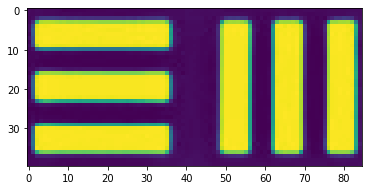

In [6]:
if target == 'HV_bars':
    obj = cv2.imread('./USAF_Resolution_Chart_A1-780.jpg', 0)[:,::-1]
    obj = cv2.resize(obj, (500,500))/255.0
    obj = obj[73+7:139-19,60:145]
elif target == 'H_bars':
    obj = cv2.imread('./1963_test_chart.png', 0)[:,::-1]
    obj = 1-cv2.resize(obj, (1000,1000),cv2.INTER_NEAREST)/255.0
    obj = obj[50:180,125:255]
    obj = obj[15:60,100:135]
    obj = cv2.resize(obj, (50,100),cv2.INTER_NEAREST)/255.0
    obj = cv2.rotate(obj, cv2.cv2.ROTATE_90_CLOCKWISE)
    
print(obj.shape)
plt.imshow(obj)
plt.show()
obj = torch.from_numpy(obj.astype(np.complex128)).to(device)
obj = pad_to_size(obj,N)*(1-1e-10)+1e-10

## Forward Model

#### propagation

#### camera model

In [7]:
class Camera:
    def __init__(self, fl, p, m, n, n_photons=None, saturation=None):
        # fl: focal length of the camera
        # p: pixel pitch size of the sensor
        # m: pixel number of vertical direction
        # n: pixel number of horizontal direction
        self.fl = fl
        self.p = p
        self.m = m
        self.n = n
        self.sensor_img = None
        self.n_photons = n_photons
        self.saturation = saturation

    ### project from the screen to the sensor
    def wall2sensor(self,img, R, t, pitch):
        ## R, t: world coor plane (Z=0) to cam coor
        ratio = 1
        while self.p/ratio*np.linalg.norm(t)/self.fl > 2*pitch:
            ratio += 1
        X_coor, Y_coor = np.meshgrid(np.arange(-(self.n*ratio)//2,(self.n*ratio)//2),np.arange(-(self.m*ratio)//2,(self.m*ratio)//2))
        X_cam, Y_cam = X_coor*self.p/ratio, Y_coor*self.p/ratio

        Z = -t[2]/(R[2, 2]+X_cam*R[0, 2]/self.fl) ## (x,y,z) in cam coor on the screen satisfies R^T.dot([x, y, z])_3 + t_3 = 0 (plane z=0) => ...

        p_cam = np.stack([X_cam*Z/self.fl, Y_cam*Z/self.fl, Z]).reshape((3,-1))
        p = R.T.dot(p_cam)+t
        Xs_coor, Ys_coor = p[0]/pitch, p[1]/pitch
        Xs_coor, Ys_coor = Xs_coor.reshape(X_coor.shape), Ys_coor.reshape(Y_coor.shape)
        size = int(max(Xs_coor.max()-Xs_coor.min(), Ys_coor.max()-Ys_coor.min()))
        self.sensor_img = Camera.bilinear_interp(np.pad(img,((size,size),(size,size))), Ys_coor, Xs_coor)
        self.sensor_img = np.clip(self.sensor_img, 0, 1e10)
        if self.n_photons is not None:
            self.sensor_img = np.random.poisson(self.sensor_img*self.n_photons)
            print(self.sensor_img.max())
            if self.saturation is not None:
                self.sensor_img = np.clip(self.sensor_img, 0, self.saturation)/self.saturation
            else:
                self.sensor_img = self.sensor_img/self.n_photons
                
        if ratio > 1:
            self.sensor_img = Camera.binning(self.sensor_img, ratio)
            print(ratio)

    def read_out_img(self):
        return self.sensor_img

    @staticmethod
    def bilinear_interp(img, Y_coor, X_coor):
        Y_coor_int, X_coor_int = np.floor(Y_coor).astype('int'), np.floor(X_coor).astype('int')
        delta_Y, delta_X = Y_coor-Y_coor_int, X_coor-X_coor_int
        m, n = img.shape
        Y_coor_int, X_coor_int = Y_coor_int+m//2, X_coor_int+n//2

        img_interp=(1-delta_Y)*(1-delta_X)*img[Y_coor_int,X_coor_int]+\
                        (delta_Y)*(1-delta_X)*img[Y_coor_int+1,X_coor_int]+\
                        (1-delta_Y)*(delta_X)*img[Y_coor_int,X_coor_int+1]+\
                        (delta_Y)*(delta_X)*img[Y_coor_int+1,X_coor_int+1]
        return img_interp

    @staticmethod
    def binning(img, ratio):
        return block_reduce(img, block_size=(ratio,ratio), func=np.mean)

change here according to the real setting

In [8]:
### camera extrinsic parameters
theta = np.arcsin(2.27/100) # in meters. Nominator: laser <-> telescope Dominator: telescope <-> screen
R = np.array([[np.cos(theta), 0, -np.sin(theta)],
     [0, 1, 0],
     [np.sin(theta), 0, np.cos(theta)]])
t = np.array([[-2270, 0, -2270/np.tan(theta)]]).T # in mm. 22700mm = 22.7m


In [9]:
cam = Camera(2350, 1.85e-3, 3000, 4000)

## Phase Retrieval

#### generate data
change distances and other parameters according to above blocks

/home/u5/zhipengdong/.local/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


462
torch.Size([240, 320])


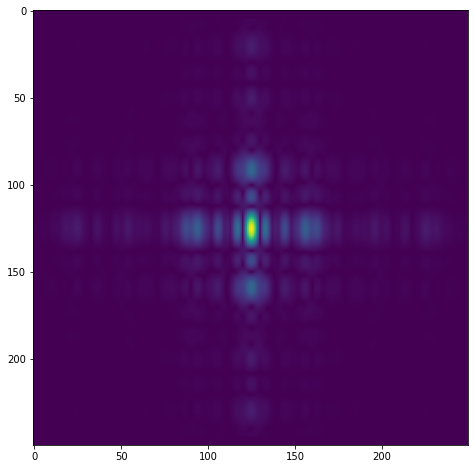

In [10]:
p_out = 1e-3 # output field pixel unit
z = [3.5] # propagation distance of the object field
k = 1

num_planes= len(z)
fig = plt.figure(figsize=(16, 8))

for offset in z:
    img = CUFFT(obj, offset, lam, unit, p_out) # Fourier transform of the inout object
    m, n = img.shape
    print(m)
    
    img_amp = torch.abs(img)/torch.abs(img).max() # Normalization of the FT
    img_amp = cu_rescale(img_amp**2, 1000/80) ## field to intensity & gsd matching from output field pixel unit to telescope
    
    cam.wall2sensor(img_amp.to('cpu').numpy(), R, t, 80*1e-3) # screen to sensor projection
    cam_img = np.sqrt(cam.read_out_img()) # camera readout image
    
    img = cu_rescale(torch.from_numpy(cam_img).to(device), 80/1000) # gsd matching from telescope to output field pixel unit
    
    print(img.shape)
    img = pad_to_size(img, m) if img.shape[0] < m else crop_to_size(img, m) ## add enough padding
    plt.subplot(1,num_planes,k)
    plt.imshow(crop_to_size(torch.abs(img).to('cpu').numpy(),250))
    k+=1
plt.show()


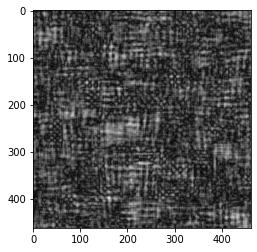

Amplitude shape: torch.Size([462, 462]), dtype: torch.float64
Amplitude stat: max: 4.175652580882429e-10, min: 1.5471113955300395e-13, mean: 1.0854859583962998e-10, std: 5.5992643055592075e-11


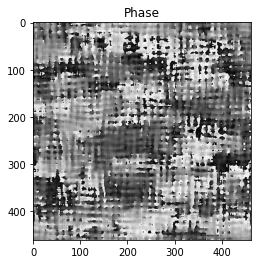

Phase shape: torch.Size([462, 462]), dtype: torch.float64
Phase stat: max: 3.14158825326167, min: -3.1415649572964743, mean: 1.355629989940537e-05, std: 1.732117980728054


In [11]:
target_est = CUIFFT(torch.abs(img)*torch.exp(1j*torch.pi*(torch.randn_like(torch.abs(img)))), offset, lam, p_out) 
# initial guess of the object 
show_stats(target_est)

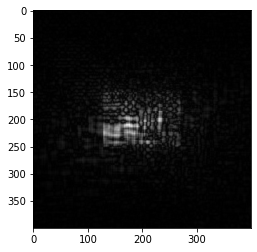

Amplitude shape: torch.Size([400, 400]), dtype: torch.float64
Amplitude stat: max: 1.7806386215429733e-09, min: 1.1144246048909518e-14, mean: 5.848434035940139e-11, std: 1.2794184799149176e-10


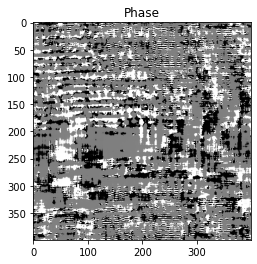

Phase shape: torch.Size([400, 400]), dtype: torch.float64
Phase stat: max: 3.1415918705831443, min: -3.141592195978852, mean: -0.024052259987827798, std: 2.1244943668506275


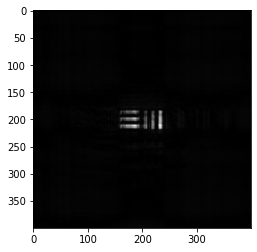

Amplitude shape: torch.Size([400, 400]), dtype: torch.float64
Amplitude stat: max: 3.2723476195166833e-09, min: 3.37029084400004e-14, mean: 4.6824428093803596e-11, std: 1.2926654978519773e-10


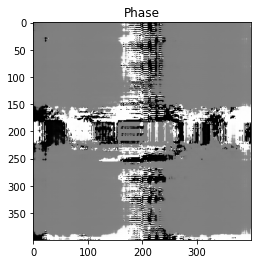

Phase shape: torch.Size([400, 400]), dtype: torch.float64
Phase stat: max: 3.141592644180032, min: -3.141592518974273, mean: 0.07732856592760184, std: 1.6040748485844019


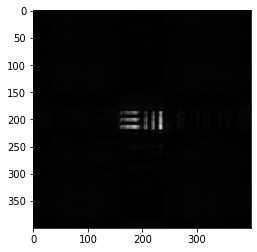

Amplitude shape: torch.Size([400, 400]), dtype: torch.float64
Amplitude stat: max: 3.5081978229932554e-09, min: 2.8843672179383683e-14, mean: 4.6517073375431393e-11, std: 1.2935406658915275e-10


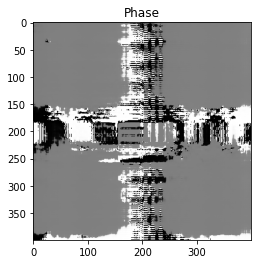

Phase shape: torch.Size([400, 400]), dtype: torch.float64
Phase stat: max: 3.141586368956901, min: -3.1415906327484735, mean: 0.09598864281841962, std: 1.6018981424568843


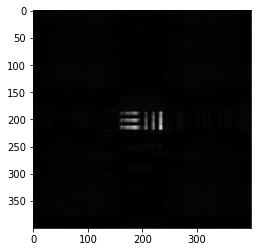

Amplitude shape: torch.Size([400, 400]), dtype: torch.float64
Amplitude stat: max: 3.402957172925245e-09, min: 2.407750209257589e-14, mean: 4.63290852593551e-11, std: 1.2939655217159775e-10


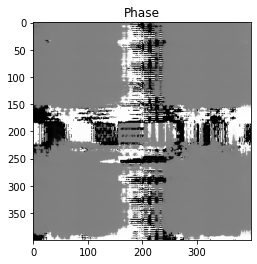

Phase shape: torch.Size([400, 400]), dtype: torch.float64
Phase stat: max: 3.1415925887012572, min: -3.1415798037989195, mean: 0.0935092864926949, std: 1.601129212721072


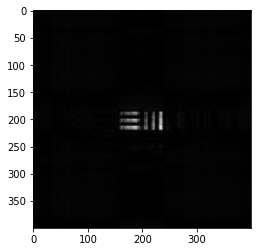

Amplitude shape: torch.Size([400, 400]), dtype: torch.float64
Amplitude stat: max: 3.2851983168070896e-09, min: 5.742821884720822e-14, mean: 4.627270979778686e-11, std: 1.2941037050995797e-10


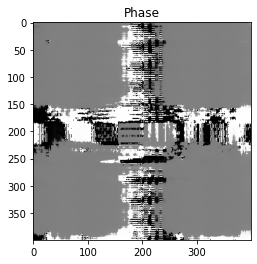

Phase shape: torch.Size([400, 400]), dtype: torch.float64
Phase stat: max: 3.1415921806298224, min: -3.141589152632679, mean: 0.08758506284660023, std: 1.6011552857012492


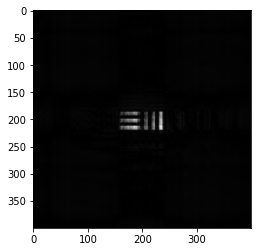

Amplitude shape: torch.Size([400, 400]), dtype: torch.float64
Amplitude stat: max: 3.1906219308232168e-09, min: 1.808862341307219e-14, mean: 4.621596991679341e-11, std: 1.294405947157835e-10


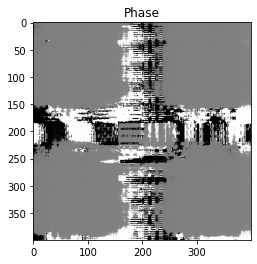

Phase shape: torch.Size([400, 400]), dtype: torch.float64
Phase stat: max: 3.141587613458313, min: -3.1415921888249914, mean: 0.08244231130629903, std: 1.6016490620411885


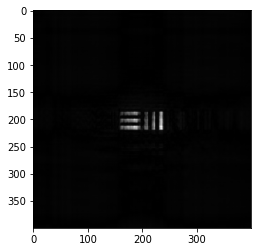

Amplitude shape: torch.Size([400, 400]), dtype: torch.float64
Amplitude stat: max: 3.1774611115550686e-09, min: 6.537220337101891e-14, mean: 4.6152409682542174e-11, std: 1.294825011199216e-10


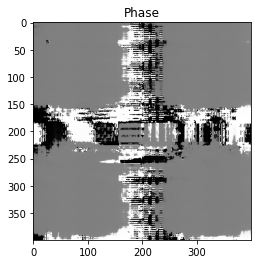

Phase shape: torch.Size([400, 400]), dtype: torch.float64
Phase stat: max: 3.1415917841849117, min: -3.141585108988679, mean: 0.08540483432448409, std: 1.6030264965718577


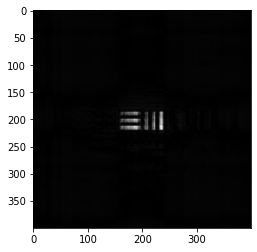

Amplitude shape: torch.Size([400, 400]), dtype: torch.float64
Amplitude stat: max: 3.126029430961275e-09, min: 2.088606074896298e-14, mean: 4.6084732516837506e-11, std: 1.295230734296766e-10


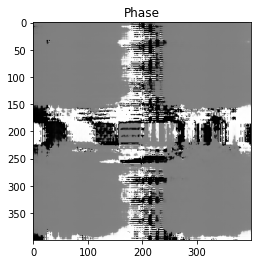

Phase shape: torch.Size([400, 400]), dtype: torch.float64
Phase stat: max: 3.1415923210713994, min: -3.1415897055421946, mean: 0.08776485618617597, std: 1.6037718656541353


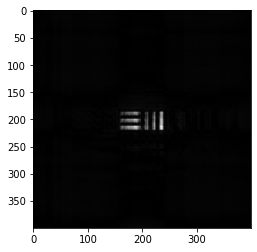

Amplitude shape: torch.Size([400, 400]), dtype: torch.float64
Amplitude stat: max: 3.1644819252054336e-09, min: 1.1841703781268906e-14, mean: 4.6062965693928174e-11, std: 1.2953501406468103e-10


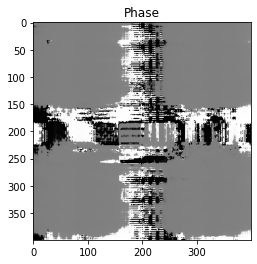

Phase shape: torch.Size([400, 400]), dtype: torch.float64
Phase stat: max: 3.1415797358413067, min: -3.141590354345655, mean: 0.0854778632267651, std: 1.6041598675590956


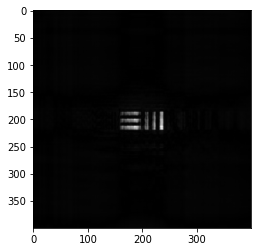

Amplitude shape: torch.Size([400, 400]), dtype: torch.float64
Amplitude stat: max: 3.139368565141399e-09, min: 1.3263608423505716e-14, mean: 4.607042608714475e-11, std: 1.295344366716698e-10


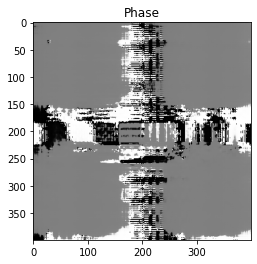

Phase shape: torch.Size([400, 400]), dtype: torch.float64
Phase stat: max: 3.141591887938659, min: -3.1415866712141236, mean: 0.08826540302132076, std: 1.6034184084645966


In [12]:
# iterations %%time
measurements_est = img
n = 1000
if target == 'HV_bars':
    h_pad, w_pad = 180, 160 
elif target == 'H_bars':
    h_pad, w_pad = 178, 150

for iter in range(n):
    target_est = torch.abs(target_est)
    # specify the target interested area
    target_est[:h_pad] = 1e-10
    target_est[-h_pad:] = 1e-10
    target_est[:,:w_pad] = 1e-10
    target_est[:,-w_pad:] = 1e-10
    field_at_target = target_est
    
    sc = CUFFT(field_at_target, offset ,lam, unit, p_out)
    measurements_est = torch.abs(img)*torch.exp(1j*torch.angle(sc))
    field_at_target_inv = CUIFFT(measurements_est, offset, lam, p_out)
    target_est = crop_to_size(field_at_target_inv, N, 0)
    if iter % 100 == 0:
        show_stats(crop_to_size(target_est, N))

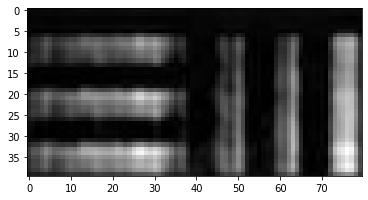

In [13]:
plt.imshow(torch.abs(target_est).to('cpu').numpy()[h_pad:-h_pad, w_pad:-w_pad], cmap='gray')
plt.show()